In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as transforms

# self-defined functions
from utils import plot_help
from pipelines import nst, mask_and_crop_iris

# disable plt warnings when too many images are plotted
plt.rcParams.update({'figure.max_open_warning': 0})

# GPU
device = 'cuda:0'

# transforms
t_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale = True)])
t_rgb2bw = transforms.functional.rgb_to_grayscale
t_resize1 = transforms.Resize((224, 224))

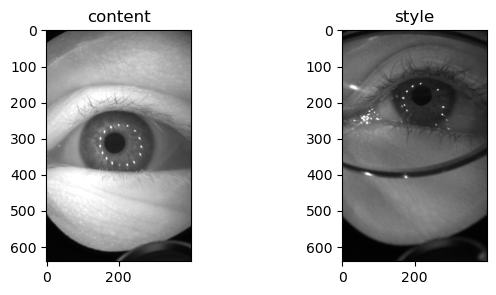

In [2]:
# load images
c_img = Image.open('images/000000339816.png').convert('L')
s_img = Image.open('images/000000240703.png').convert('L')
c_img = t_tensor(c_img)
s_img = t_tensor(s_img)

plot_help(images = [c_img, s_img], titles = ['content', 'style'])

c iris shape: torch.Size([171, 206])


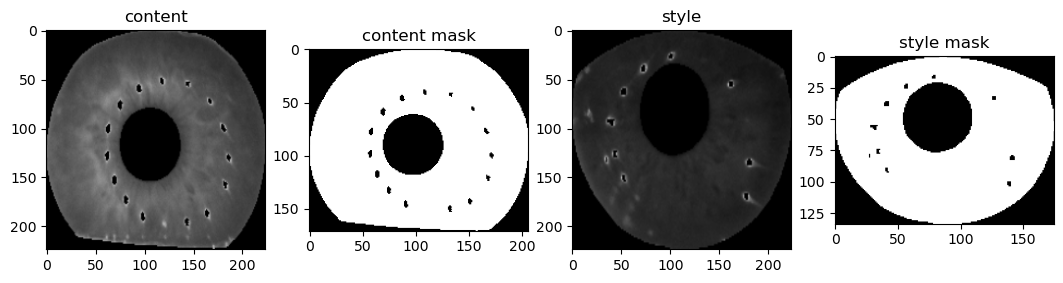

In [3]:
# mask out non-iris parts, trim black border, and remove glints
c_masked_cropped, c_mask, c_x_min, c_y_min, c_x_max, c_y_max = mask_and_crop_iris(c_img, device = device)
s_masked_cropped, s_mask, _, _, _, _ = mask_and_crop_iris(s_img, device = device)

print('c iris shape:', c_masked_cropped.shape[-2:])
t_resize2 = transforms.Resize(c_masked_cropped.shape[-2:])
c_masked_cropped = t_resize1(c_masked_cropped)
s_masked_cropped = t_resize1(s_masked_cropped)

plot_help(images = [c_masked_cropped, c_mask, s_masked_cropped, s_mask], titles = ['content', 'content mask', 'style', 'style mask'])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.20it/s]


epoch: 0 c_loss: 0.000 s_loss: 2.532


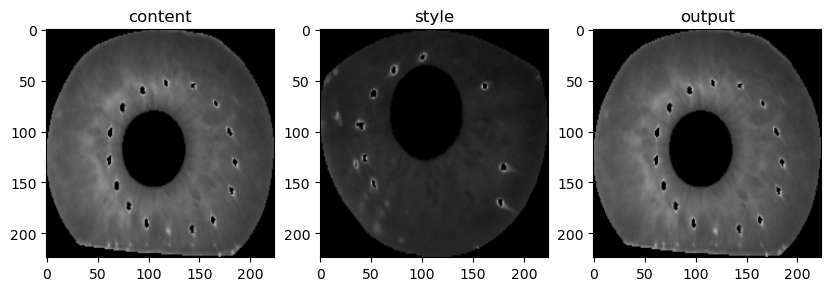

epoch: 20 c_loss: 1.761 s_loss: 0.173


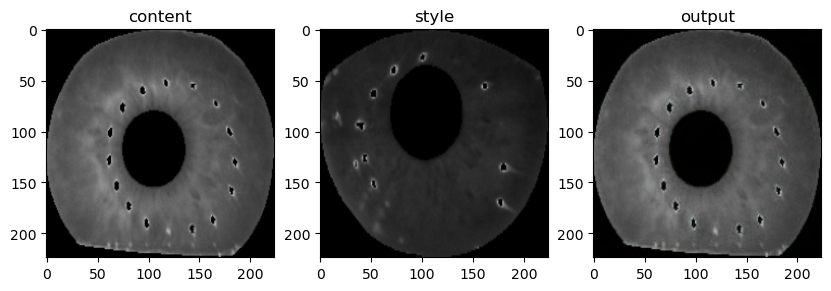

epoch: 40 c_loss: 1.991 s_loss: 0.084


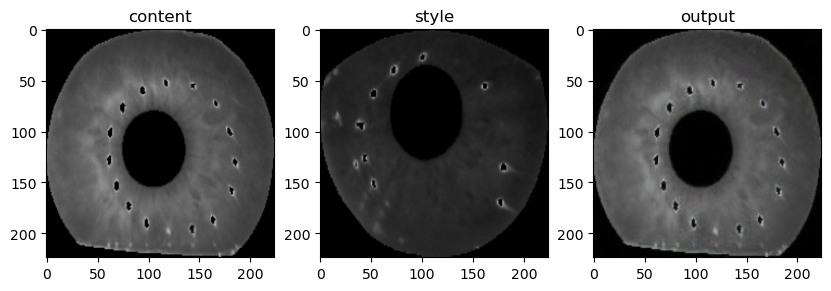

epoch: 60 c_loss: 2.105 s_loss: 0.057


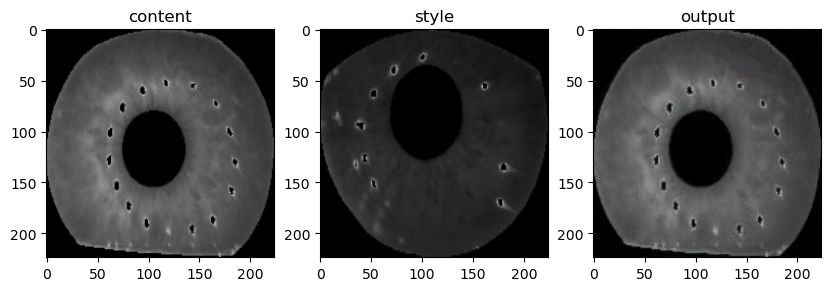

epoch: 80 c_loss: 2.195 s_loss: 0.045


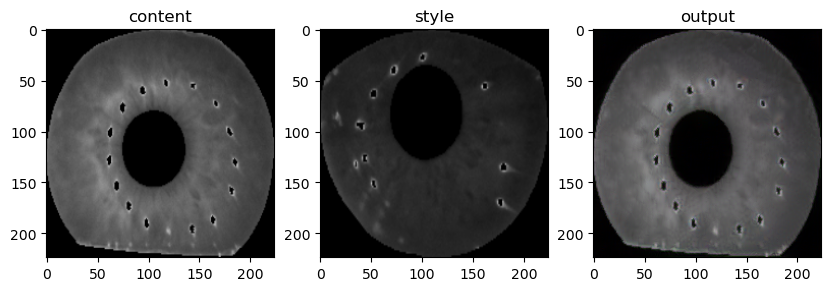

epoch: 100 c_loss: 2.263 s_loss: 0.038


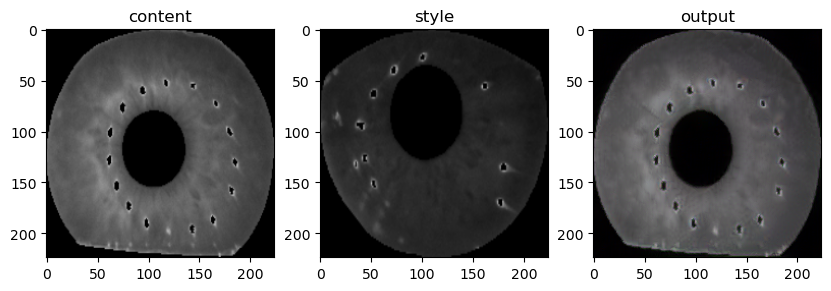

epoch: 120 c_loss: 2.322 s_loss: 0.035


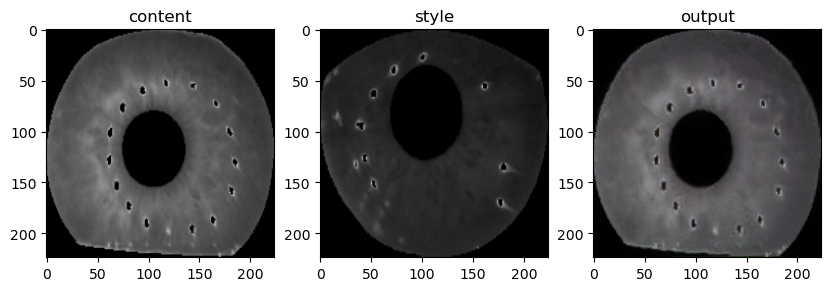

epoch: 140 c_loss: 2.373 s_loss: 0.033


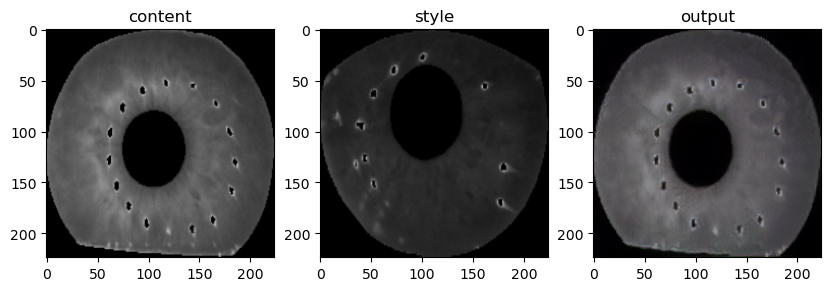

epoch: 160 c_loss: 2.425 s_loss: 0.031


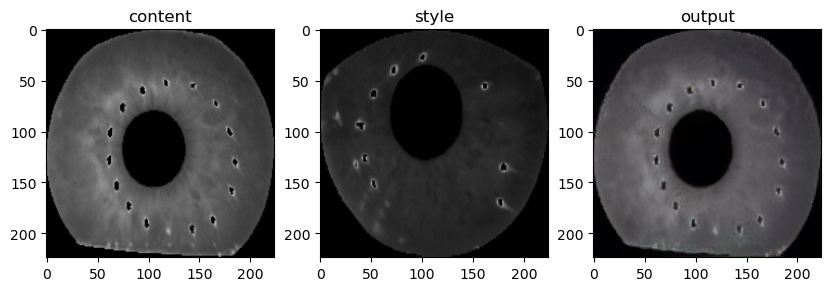

epoch: 180 c_loss: 2.608 s_loss: 0.067


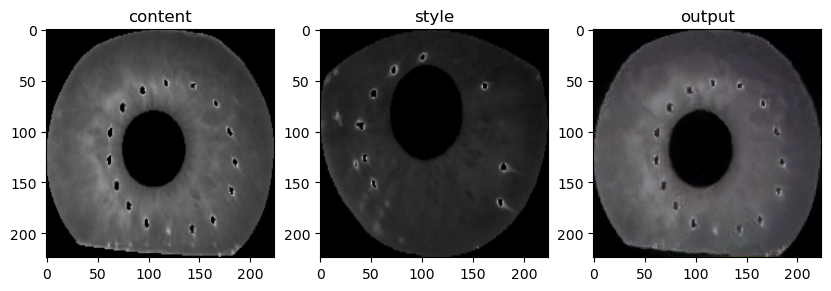

final c_loss: 2.490 s_loss: 0.029


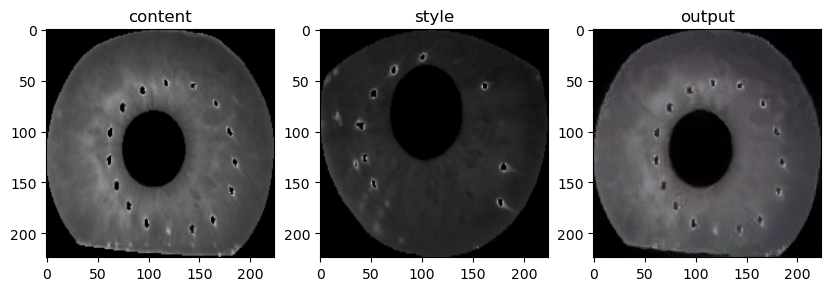

In [4]:
# iris style transfer main function
x, x_hist, c_loss_hist, s_loss_hist = nst(c_masked_cropped, s_masked_cropped, c_loss_weight = 0, s_loss_weight = 1, device = device)

# plots
plot_period = 20
for i in range(0, len(x_hist), plot_period):
    print('epoch:', i, 'c_loss:', '{0:.3f}'.format(c_loss_hist[i]), 's_loss:', '{0:.3f}'.format(s_loss_hist[i]))
    plot_help(images = [c_masked_cropped, s_masked_cropped, x_hist[i]], titles = ['content', 'style', 'output'])

print('final', 'c_loss:', '{0:.3f}'.format(c_loss_hist[-1]), 's_loss:', '{0:.3f}'.format(s_loss_hist[-1]))
plot_help(images = [c_masked_cropped, s_masked_cropped, x], titles = ['content', 'style', 'output'])

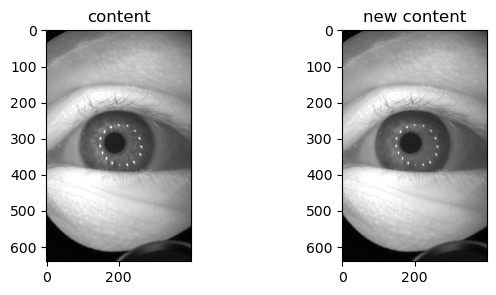

In [5]:
# swap in stylized iris and add back glints
new_c_img = c_img.clone()
x = t_resize2(x)
x = t_rgb2bw(x)
new_c_img[:, c_x_min: c_x_max + 1, c_y_min: c_y_max + 1] *= ~c_mask.cpu()
new_c_img[:, c_x_min: c_x_max + 1, c_y_min: c_y_max + 1] += (x * c_mask).cpu()

plot_help(images = [c_img, new_c_img], titles = ['content', 'new content'])